# About

These is a base solution of PID.

In [2]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import XGBoostClassifier

# Directories

In [3]:
track = 'Long'
particle = 'Electron'

data_path = "../../../data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
"multiclass/Long/Keras"

netconfig_path = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Read data

In [4]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

In [9]:
data = pandas.read_csv(data_path + "/data_train.csv")

In [20]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

# Balance data

In [21]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  170119
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  774220
Size of class 4 is  138261
Size of class 5 is  81951


In [22]:
selected_indexes = []

numpy.random.seed = 42

for i in numpy.unique(labels):
    
    indxs = numpy.random.choice(data.index[labels == i], 
                                size=min(50000, len(labels[labels == i])), 
                                replace=False)
    
    selected_indexes += list(indxs)

In [23]:
data.loc[selected_indexes].to_csv(data_path + "/data_train_balanced.csv")

# Read balanced data

In [5]:
data = pandas.read_csv(data_path + "/data_train_balanced.csv")

In [6]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [7]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  50000
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  50000
Size of class 4 is  50000
Size of class 5 is  50000


# Features

In [8]:
features = [
 'BremPIDe',
 'CaloNeutralPrs',
 'CaloNeutralSpd',
 'InAccBrem',
 'InAccSpd',
 'CaloPrsE',
 'InAccPrs',
 'HcalPIDe',
 'CaloHcalE',
 'InAccHcal',
 'CaloTrajectoryL',
 'EcalPIDe',
 'CaloNeutralEcal',
 'CaloTrMatch',
 'CaloElectronMatch',
 'CaloChargedPrs',
 'CaloChargedSpd',
 'MuonNShared',
 'CaloBremMatch',
 'MuonIsLooseMuon',
 'MuonIsMuon',
 'MuonBkgLL',
 'InAccEcal',
 'MuonMuLL',
 #'TrackMatchChi2', # all missing values
 'TrackGhostProbability',
 'TrackType',
 'EcalPIDmu',
 'TrackPt',
 'TrackP',
 'RichAboveMuThres',
 'InAccMuon',
 'TrackChi2PerDof',
 'TrackNumDof',
 'CombDLLmu',
 'CaloSpdE',
 'PrsPIDe',
 'HcalPIDmu',
 'TrackFitMatchChi2',
 'CombDLLpi',
 'RichDLLbt',
 'TrackHistory',
 'RichDLLpi',
 'TrackFitVeloNDoF',
 'CombDLLp',
 'TrackFitTChi2',
 'TrackFitTNDoF',
 'RichAboveElThres',
 'TrackDOCA',
 'RichDLLe',
 'CombDLLe',
 'CombDLLk',
 'TrackFitVeloChi2',
 'RichDLLp',
 'RichUsedR1Gas',
 'RichUsedR2Gas',
 'CaloEcalE',
 'RichAbovePiThres',
 'CaloChargedEcal',
 'RichAboveKaThres',
 'RichAbovePrThres',
 'RichDLLmu',
 'RichDLLk']
#  'piplus_OWNPV_X',
#  'piplus_OWNPV_Y',
#  'piplus_OWNPV_Z',
#  'piplus_OWNPV_XERR',
#  'piplus_OWNPV_YERR',
#  'piplus_OWNPV_ZERR',
#  'piplus_OWNPV_CHI2',
#  'piplus_OWNPV_NDOF',
#  'piplus_IP_OWNPV',
#  'piplus_IPCHI2_OWNPV']

In [9]:
len(features)

62

# Feature histograms

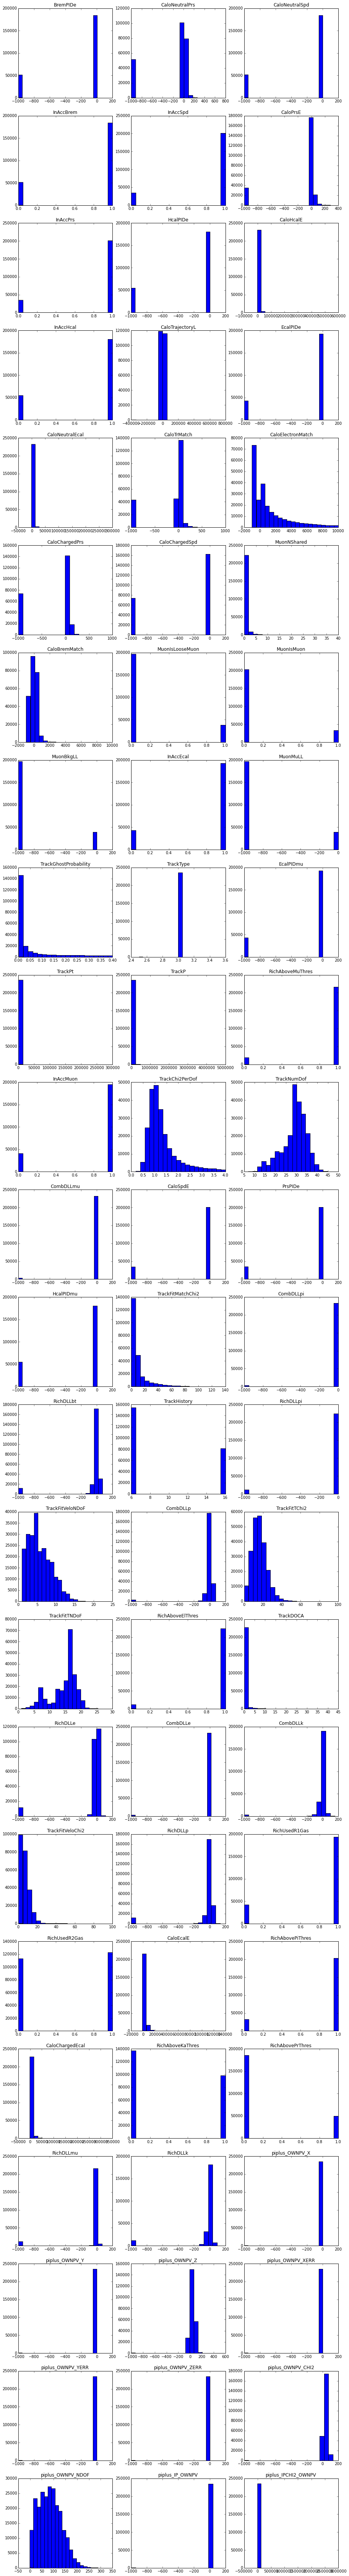

In [13]:
i=0
plt.figure(figsize=(15, 5 * (len(features)//3 + 1)))

for f in features:
    
    plt.subplot(len(features)//3 + 1, 3, i+1)
    plt.title(f)
    plt.hist(data[f].values, bins=20)
    
    i+=1
    
plt.show()

# Categorical features histograms

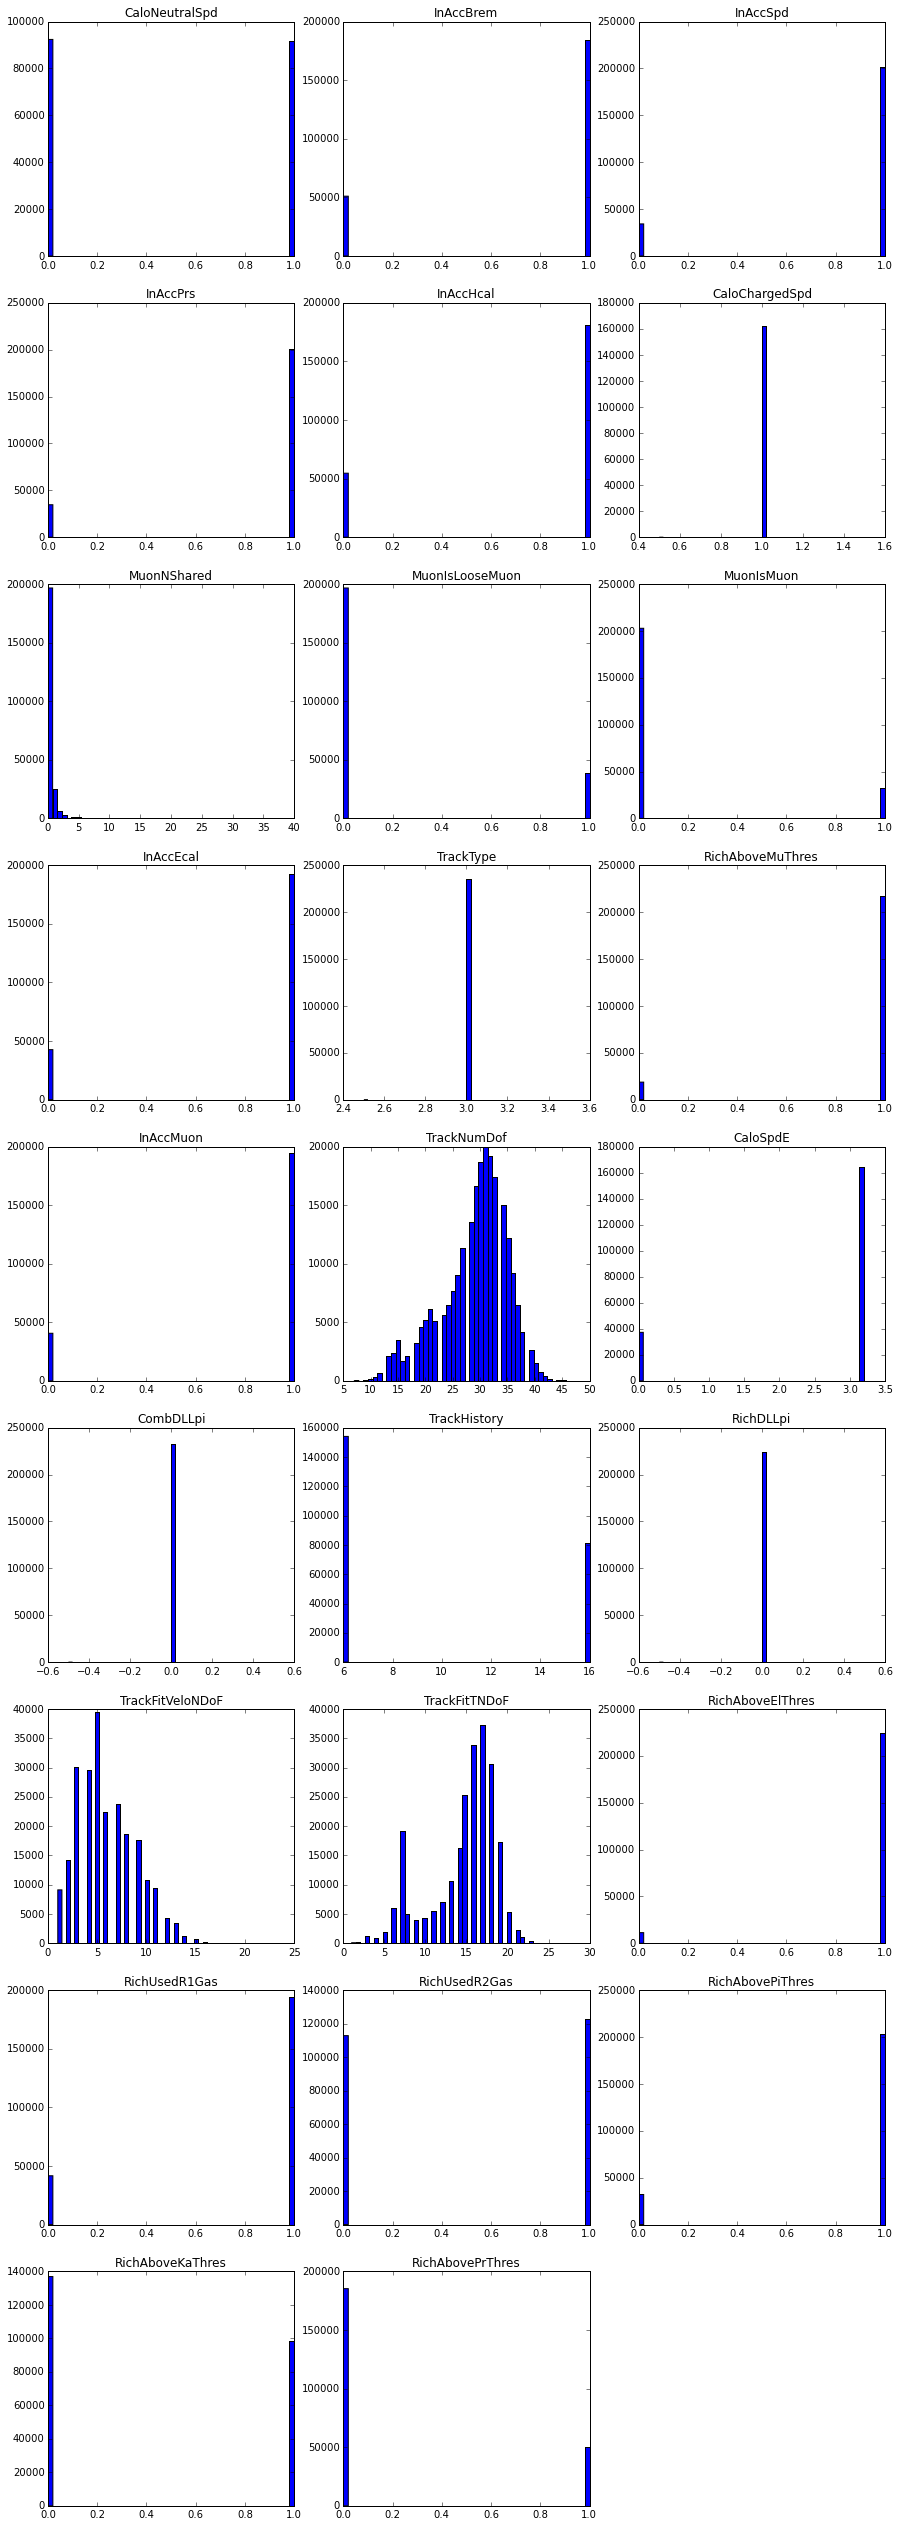

In [10]:
i=0
categorical_features = []
plt.figure(figsize=(15, 5 * (len(features)//3 + 1)))

for f in features:
    
    feature_value = data[f].values
    feature_value = feature_value[feature_value != -999.0]
    
    if len(numpy.unique(feature_value)) <= 50:
        
        categorical_features += [f]
    
        plt.subplot(len(features)//3 + 1, 3, i+1)
        plt.title(f)
        plt.hist(feature_value, bins=50)

        i+=1
    
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler, Imputer, StandardScaler

imp = Imputer(missing_values=-999.0, strategy='most_frequent', axis=0, copy=True)
imp.fit(data[categorical_features].values)

Imputer(axis=0, copy=True, missing_values=-999.0, strategy='most_frequent',
    verbose=0)

In [12]:
categorical_features

['CaloNeutralSpd',
 'InAccBrem',
 'InAccSpd',
 'InAccPrs',
 'InAccHcal',
 'CaloChargedSpd',
 'MuonNShared',
 'MuonIsLooseMuon',
 'MuonIsMuon',
 'InAccEcal',
 'TrackType',
 'RichAboveMuThres',
 'InAccMuon',
 'TrackNumDof',
 'CaloSpdE',
 'CombDLLpi',
 'TrackHistory',
 'RichDLLpi',
 'TrackFitVeloNDoF',
 'TrackFitTNDoF',
 'RichAboveElThres',
 'RichUsedR1Gas',
 'RichUsedR2Gas',
 'RichAbovePiThres',
 'RichAboveKaThres',
 'RichAbovePrThres']

# Train

In [13]:
weights = numpy.zeros(len(labels))

for one_lab in labs:
    
    weights += 0.1 * (labels == one_lab) * len(labels) / ((labels == one_lab).sum())
    
numpy.unique(weights)

array([ 0.470898  ,  0.78906465,  4.19695187])

In [14]:
for i in numpy.unique(labels):
    print "Weight of class %d is " % i, weights[labels == i][0]

Weight of class 0 is  0.470898
Weight of class 1 is  4.19695187166
Weight of class 2 is  0.789064646939
Weight of class 3 is  0.470898
Weight of class 4 is  0.470898
Weight of class 5 is  0.470898


In [15]:
from sklearn.cross_validation import train_test_split

train_inds, test_inds, labels_train, labels_test, weights_train, weights_test = train_test_split(data.index, 
                                                                                                 labels, 
                                                                                                 weights, 
                                                                                                 test_size=0.25, 
                                                                                                 random_state=42)

# Random Forest

In [16]:
X_train = imp.transform(data[categorical_features].loc[train_inds].values)
y_train = labels_train

X_test = imp.transform(data[categorical_features].loc[test_inds].values)
y_test = labels_test

In [222]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, 
                             max_features=None, 
                             max_depth=8, 
                             n_jobs=4, 
                             bootstrap=True, 
                             min_samples_leaf=10)
clf.fit(X_train, y_train, weights_train)

CPU times: user 12min 3s, sys: 1.01 s, total: 12min 4s
Wall time: 3min 49s


In [223]:
feature_ims = pandas.DataFrame()
feature_ims['Features'] = categorical_features
feature_ims['Importances'] = clf.feature_importances_
feature_ims.sort(columns=['Importances'], ascending=False)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Features,Importances
8,MuonIsMuon,0.592674
24,RichAboveKaThres,0.091341
13,TrackNumDof,0.078248
23,RichAbovePiThres,0.066391
14,CaloSpdE,0.036005
19,TrackFitTNDoF,0.032803
6,MuonNShared,0.018796
12,InAccMuon,0.018040
1,InAccBrem,0.012708
18,TrackFitVeloNDoF,0.011106


In [224]:
probas = clf.predict_proba(X_test)

In [225]:
from sklearn.metrics import log_loss

log_loss(labels_test, probas)

1.3889964289941565

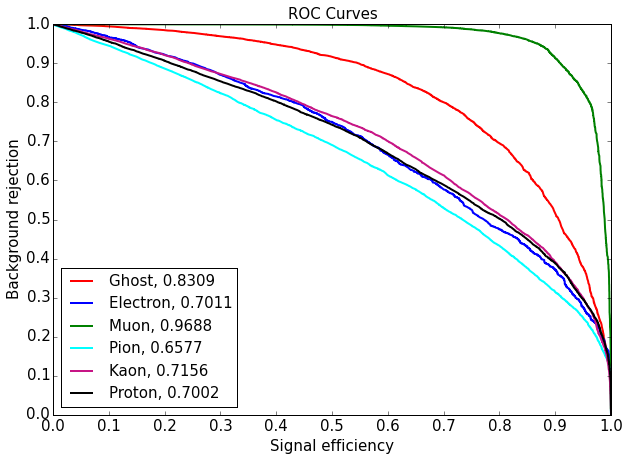

In [226]:
import os, sys
sys.path.append('../python')
import utils

utils.get_roc_curves(labels_test, probas, particles, save_path=None, show=True)

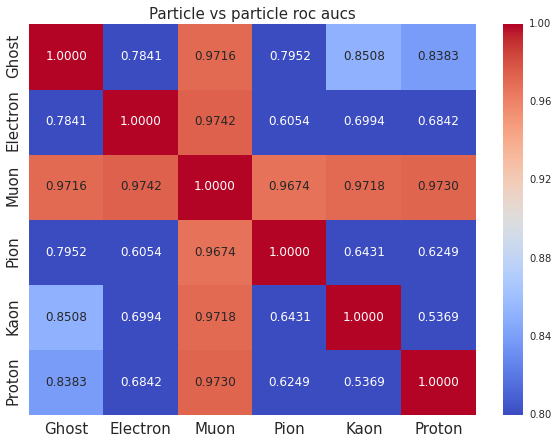

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,0.784054,0.971567,0.795212,0.850813,0.838297
Electron,0.784054,1.000000,0.974240,0.605398,0.699420,0.684213
Muon,0.971567,0.974240,1.000000,0.967369,0.971770,0.972987
Pion,0.795212,0.605398,0.967369,1.000000,0.643116,0.624874
Kaon,0.850813,0.699420,0.971770,0.643116,1.000000,0.536924
Proton,0.838297,0.684213,0.972987,0.624874,0.536924,1.000000


In [227]:
utils.get_roc_auc_matrix(labels_test, probas, particles, save_path=None, show=True)

# Keras

In [228]:
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
ss.fit(X_train)

StandardScaler(copy=False, with_mean=True, with_std=True)

In [229]:
from keras.utils import np_utils

X_train_nn = ss.transform(X_train)
y_train_nn = np_utils.to_categorical(labels_train)

X_test_nn = ss.transform(X_test)
y_test_nn = np_utils.to_categorical(labels_test)

In [ ]:
%%time
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adadelta
from keras.callbacks import EarlyStopping
from keras.regularizers import l2, activity_l2, l1, activity_l1, l1l2

clf = Sequential()
clf.add(Dense(40, input_dim=len(categorical_features), init='uniform', activation='sigmoid'))
clf.add(Dense(6, init='uniform', activation='softmax'))

sgd = SGD(lr=0.01, decay=0.0, momentum=0.0, nesterov=False)

clf.compile(loss='categorical_crossentropy',
              optimizer=sgd,
             class_mode = "categorical")

call = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='auto')


history = clf.fit(X=X_train_nn, 
                y=y_train_nn, 
                #sample_weight=weights_train,
                nb_epoch=500,
                batch_size=128,
                show_accuracy=True,
                validation_split=0.1,
                validation_data = (X_test_nn, y_test_nn),
                verbose=0,
                callbacks=[call])

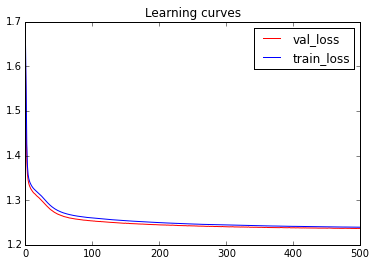

In [244]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.title('Learning curves')
plt.plot(val_loss, 'r', label='val_loss')
plt.plot(loss, 'b', label='train_loss')
plt.legend(loc='best')
plt.show()

In [245]:
probas = clf.predict_proba(X_test_nn)

58863/58863 [==============================] - 0s     


In [246]:
from sklearn.metrics import log_loss

log_loss(labels_test, probas)

1.2367089779639722

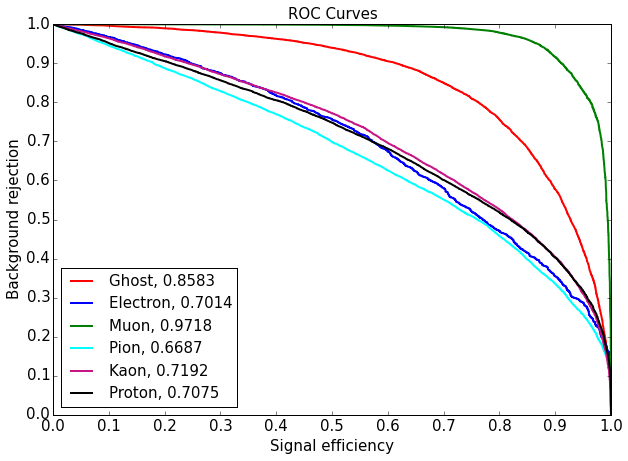

In [247]:
import os, sys
sys.path.append('../python')
import utils

utils.get_roc_curves(labels_test, probas, particles, save_path=None, show=True)

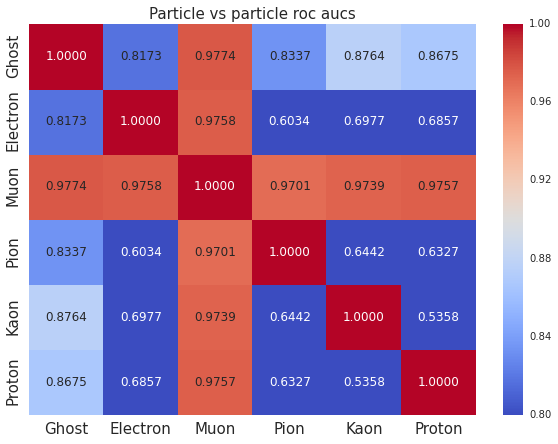

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,0.817316,0.977369,0.833654,0.876406,0.867515
Electron,0.817316,1.000000,0.975837,0.603411,0.697726,0.685671
Muon,0.977369,0.975837,1.000000,0.970117,0.973935,0.975670
Pion,0.833654,0.603411,0.970117,1.000000,0.644174,0.632685
Kaon,0.876406,0.697726,0.973935,0.644174,1.000000,0.535845
Proton,0.867515,0.685671,0.975670,0.632685,0.535845,1.000000


In [248]:
utils.get_roc_auc_matrix(labels_test, probas, particles, save_path=None, show=True)

# FastFM

In [154]:
import copy
import numpy

class OneVsRestClassifier(object):

    def __init__(self, estimator):
        """
        One vs Rest classifier based on an estimator.
        :param estimator: estimator with fit, predict, predict_proba mathods.
        :return:
        """

        self.estimator = estimator
        self.estimators_ = {}
        self.classes = []

    def fit(self, X, y, sample_weight=None):
        """
        Fit the classifier.
        :param X: the estimator's format, data
        :param y: array, shape = [n_samples], labels of classes [0, 1, 2, ..., n_classes - 1]
        :param sample_weight: None, 'balanced' or array, shape = [n_samples], sample weights.
        If 'balanced' sum of weights of positive and negative classes will be equal.
        :return:
        """

        self.classes = numpy.unique(y)

        for one_class in self.classes:

            y_class = (y == one_class) * 2. - 1. # !!!

            estimator = copy.copy(self.estimator)

            if sample_weight is None:

                estimator.fit(X, y_class)

            elif sample_weight == 'balanced':

                weights = (y == one_class) * len(y) / ((y == one_class).sum()) + \
                          (y != one_class) * len(y) / ((y != one_class).sum())

                estimator.fit(X, y_class, sample_weight = weights)

            else:

                estimator.fit(X, y_class, sample_weight)

            self.estimators_[one_class] = estimator

    def predict_proba(self, X):
        """
        Predict probabilities to belong to a class for the each class.
        :param X: the estimator's format, data
        :return: ndarray, shape = [n_samples, n_classes], probabiities.
        """

        probas = numpy.zeros((X.shape[0], len(self.classes)))

        for num, one_class in enumerate(self.classes):

            one_proba = self.estimators_[one_class].predict_proba(X)

            probas[:, num] = one_proba

        return probas

    def predict(self, X):
        """
        Predict classes.
        :param X: the estimator's format, data
        :return: array, shape = [n_samples], class labels [0, 1, 2, ..., n_classes - 1]
        """

        probas = self.predict_proba(X)

        predictions = probas.argmax(axis=1)

        return predictions


In [151]:
from sklearn.feature_extraction import DictVectorizer

X_train_fm = [ {v: k for k, v in dict(zip(i, range(len(i)))).items()}  for i in X_train]
X_test_fm = [ {v: k for k, v in dict(zip(i, range(len(i)))).items()}  for i in X_test]

v = DictVectorizer()
X_train_fm = v.fit_transform(X_train_fm)
X_test_fm = v.transform(X_test_fm)

In [214]:
%%time
from fastFM import sgd
fm = sgd.FMClassification(n_iter=10000000, init_stdev=0.1, l2_reg_w=0., l2_reg_V=0., l2_reg=0., rank=8, step_size=0.001)

fm_all = OneVsRestClassifier(fm)
fm_all.fit(X_train_fm, y_train, None)

CPU times: user 2min 20s, sys: 97 ms, total: 2min 20s
Wall time: 2min 20s


In [215]:
probas_fm = fm_all.predict_proba(X_test_fm)

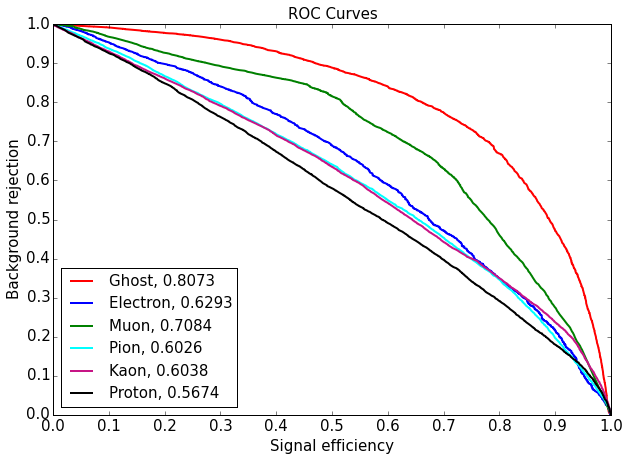

In [216]:
import os, sys
sys.path.append('../python')
import utils

utils.get_roc_curves(labels_test, probas_fm, particles, save_path=None, show=True)

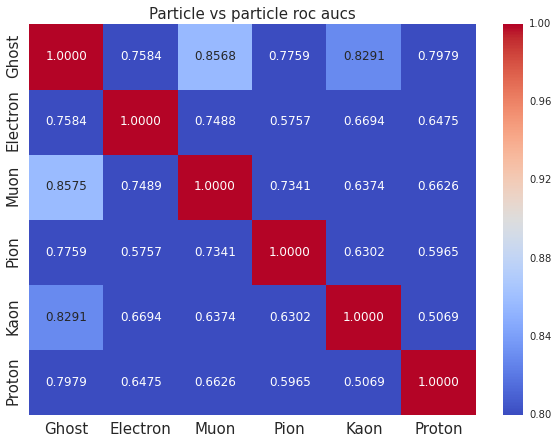

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,0.758431,0.856766,0.775910,0.829124,0.797932
Electron,0.758431,1.000000,0.748833,0.575675,0.669379,0.647491
Muon,0.857507,0.748855,1.000000,0.734073,0.637429,0.662589
Pion,0.775910,0.575675,0.734073,1.000000,0.630173,0.596509
Kaon,0.829124,0.669379,0.637430,0.630173,1.000000,0.506927
Proton,0.797931,0.647491,0.662589,0.596509,0.506927,1.000000


In [217]:
utils.get_roc_auc_matrix(labels_test, probas_fm, particles, save_path=None, show=True)